# Specific arrhythmia tests

In [4]:
import invalid_sample_detection    as invalid
import load_annotations            as annotate
import regular_activity            as regular
import numpy                       as np
import matplotlib.pyplot           as plt
import scipy
import parameters
import wfdb
from datetime import datetime

data_path = 'sample_data/challenge_training_data/'
ann_path = 'sample_data/challenge_training_multiann/'
fp_ann_path = 'sample_data/fplesinger_data/output/'
ecg_ann_type = 'gqrs'

## Asystole

In [5]:
def calc_summed_asystole_score(ann_path, 
                               sample_name, 
                               subsig, 
                               channels, 
                               ecg_ann_type, 
                               current_start, 
                               current_end,
                               verbose=False, 
                               data_fs=parameters.DEFAULT_FS): 
    summed_score = 0
    
    for channel_index, channel in zip(range(len(channels)), channels): 
        channel_type = invalid.get_channel_type(channel)
        if channel_type == "Resp": 
            continue
        
        channel_subsig = subsig[:,channel_index]
        invalids = invalid.calculate_channel_invalids(channel_subsig, channel_type)
        cval = invalid.calculate_cval_channel(invalids)
        
        ann_type = annotate.get_ann_type(channel, channel_index, ecg_ann_type)
        ann_fs = annotate.get_ann_fs(channel_type)
        
        if ecg_ann_type == 'fp': 
            path = fp_ann_path
        else: 
            path = ann_path 
        annotation = annotate.get_annotation(path + sample_name, ann_type, ann_fs, current_start, current_end)
                
        if len(annotation) == 0: 
            continue            
        elif len(annotation[0]) > 0: 
            current_score = -cval
        else: 
            current_score = cval        
        
        if verbose: 
            plt.figure(figsize=[7,5])
            plt.plot(channel_subsig, 'g-')
            annotation_seconds = annotation[0] / float(ann_fs)
            ann_x = [ (seconds - current_start) * data_fs for seconds in annotation_seconds ]
            ann_y = [ channel_subsig[index] for index in ann_x ]
            plt.plot(ann_x, ann_y, 'bo', markersize=8)
            plt.show()

            print sample_name + ": " + channel + " [" + str(current_start) + ", " + str(current_end) + "] " + str(current_score)
        
        summed_score += current_score        
        
    return summed_score   

In [6]:
def test_asystole(data_path, ann_path, sample_name, ecg_ann_type, verbose=False): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
    fs = fields['fs']
        
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    current_start = start
    current_end = current_start + parameters.ASYSTOLE_WINDOW_SIZE
    
    max_score = 0
    
    while current_end < end: 
        subsig = sig[current_start*fs:current_end*fs,:]
        summed_asystole_score = calc_summed_asystole_score(ann_path, sample_name, subsig, channels, ecg_ann_type,
                                                           current_start, current_end, verbose)
        max_score = max(max_score, summed_asystole_score)
        
        current_start += parameters.ASYSTOLE_ROLLING_INCREMENT
        current_end = current_start + parameters.ASYSTOLE_WINDOW_SIZE
    
    if verbose: 
        print sample_name + " has max asystole score: " + str(max_score)
    
    return max_score > 0
    
# sample_name = "a653l"
sample_name = "a670s" # "a203l" # true alarm
# # sample_name = "a152s" # false alarm
# print test_asystole(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

## Bradycardia

In [7]:
def get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end): 
    channels = fields['signame']
    rr_intervals_list = []
    
    for channel_index in range(len(channels)): 
        channel_name = channels[channel_index]
        channel_type = invalid.get_channel_type(channel_name)
        if channel_type == "Resp": 
            continue
            
        if ecg_ann_type == 'fp': 
            path = fp_ann_path
        else: 
            path = ann_path 
            
        rr_intervals = annotate.get_channel_rr_intervals(path, sample_name, channel_index, fields,
                                                         ecg_ann_type, start, end)
        rr_intervals_list.append(rr_intervals)
        
    return rr_intervals_list


# Precondition: len(rr_intervals_list) > 0
# Return RR intervals with the min stdev of all the RR intervals in the list
def min_stdev_rr_intervals(rr_intervals_list): 
    opt_rr_intervals = []
    min_stdev = float('inf')
    
    for rr_intervals in rr_intervals_list:  
        stdev = np.std(rr_intervals)
        if stdev < min_stdev: 
            opt_rr_intervals = rr_intervals
            min_stdev = stdev
    
    return opt_rr_intervals

In [8]:
# Best channel: minimum stdev with acceptable RR intervals sum and count
# If none with acceptable RR interval sum and count --> select minimum stdev out of all RR intervals
def find_best_channel(rr_intervals_list, alarm_duration): 
    count_and_sum = []
    only_one_test = []
    for rr_intervals in rr_intervals_list: 
        sum_check = regular.check_sum_rr_intervals(rr_intervals, alarm_duration)
        num_check = regular.check_num_rr_intervals(rr_intervals)
        
        if sum_check and num_check: 
            count_and_sum.append(rr_intervals)
        
        elif sum_check or num_check: 
            only_one_test.append(rr_intervals)

    if len(count_and_sum) > 0: 
        return min_stdev_rr_intervals(count_and_sum)
    
    if len(only_one_test) > 0: 
        return min_stdev_rr_intervals(only_one_test)
    
    return min_stdev_rr_intervals(rr_intervals_list)            

In [9]:
def get_min_hr(rr_intervals, num_beats_per_block): 
    min_hr = float('inf')
    
    for index in range(num_beats_per_block, len(rr_intervals)): 
        subsection = rr_intervals[index - num_beats_per_block:index]
        hr = float(num_beats_per_block) / sum(subsection) * parameters.NUM_SECS_IN_MIN
        min_hr = min(min_hr, hr)
        
    return min_hr

In [10]:
def test_bradycardia(data_path, ann_path, sample_name, ecg_ann_type, verbose=False): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']

    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    rr_intervals_list = get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end)    
    best_channel_rr = find_best_channel(rr_intervals_list, alarm_duration)
    min_hr = get_min_hr(best_channel_rr, parameters.BRADYCARDIA_NUM_BEATS)
    
    if verbose: 
        print sample_name + " with min HR: " + str(min_hr)
    
    return min_hr < parameters.BRADYCARDIA_HR_MIN

# sample_name = "b497l" # "b187l" #"b495l" # true alarm
# # sample_name = "b216s" #"b184s" # false alarm
# print test_bradycardia(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

## Tachycardia

In [11]:
def check_tachycardia_channel(rr_intervals_list, alarm_duration): 
    for rr_intervals in rr_intervals_list: 
        stdev_check = regular.check_rr_stdev(rr_intervals)
        sum_check = regular.check_sum_rr_intervals(rr_intervals, alarm_duration)
        hr_check = regular.check_heart_rate(rr_intervals, alarm_duration)
        if stdev_check and sum_check and not hr_check:
            return True
            
    return False

In [12]:
def get_max_hr(rr_intervals, num_beats_per_block): 
    max_hr = -float('inf')
    
    for index in range(num_beats_per_block, len(rr_intervals)): 
        subsection = rr_intervals[index - num_beats_per_block:index]
        hr = float(num_beats_per_block) / sum(subsection) * parameters.NUM_SECS_IN_MIN
        max_hr = max(max_hr, hr)
        
    return max_hr

In [13]:
def test_tachycardia(data_path, ann_path, sample_name, ecg_ann_type, verbose=False): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in s#econds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    rr_intervals_list = get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end)    
    if check_tachycardia_channel(rr_intervals_list, alarm_duration): 
        return True
    
    best_channel_rr = find_best_channel(rr_intervals_list, alarm_duration)    
    max_hr = get_max_hr(best_channel_rr, parameters.TACHYCARDIA_NUM_BEATS)
    
    if verbose: 
        print sample_name + " with max HR: " + str(max_hr)
    
    return max_hr > parameters.TACHYCARDIA_HR_MAX

sample_name = "t700s" # "t418s" # "t209l" # true alarm
# sample_name = "t384s" # false alarm
# print test_tachycardia(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

## Ventricular tachycardia

In [14]:
def hilbert_transform(x, fs, f_low, f_high, demod=False):
    N = len(x)
    f = scipy.fftpack.fft(x, n=N)
    i_high = int(np.floor(float(f_high)/fs*N))
    i_low = int(np.floor(float(f_low)/fs*N))
    win = scipy.signal.hamming( i_high - i_low )
    
    f[0:i_low] = 0
    f[i_low:i_high] = f[i_low:i_high]*win
    f[i_high+1:] = 0
    
    if demod==True:
        # demodulate the signal, i.e. shift the freq spectrum to 0
        i_mid = int( np.floor((i_high+i_low)/2.0) )
        f = np.concatenate( [f[i_mid:i_high], np.zeros(len(f)-(i_high-i_low)), f[i_low:i_mid] ]  )
        
    return 2*np.abs(scipy.fftpack.ifft(f, n=N))

In [15]:
# Returns index of peak (max value) in the signal out of the indices provided
def get_peak_index(signal, peak_indices): 
    max_peak_value = 0
    max_peak_index = 0
    
    for index in peak_indices: 
        if signal[index] > max_peak_value: 
            max_peak_value = signal[index]
            max_peak_index = index
    
    return max_peak_index

# Groups together indices for a single peak and outputs a list of peaks (one sample per peak)
# param index_threshold: minimum difference in sample number to be classified as a different peak
def get_single_peak_indices(signal, peak_indices, index_threshold=50): 
    single_peak_indices = np.array([])
    current_peak_indices = []
    prev_index = peak_indices[0]
    
    for index in peak_indices[1:]: 
        if abs(prev_index - index) > index_threshold: 
            peak_index = get_peak_index(signal, current_peak_indices)
            single_peak_indices = np.append(single_peak_indices, peak_index)
            current_peak_indices = [index]
        else: 
            current_peak_indices.append(index)
        
        prev_index = index

    # Handle the last peak
    peak_index = get_peak_index(signal, current_peak_indices)
    single_peak_indices = np.append(single_peak_indices, peak_index)
    
    return single_peak_indices

In [16]:
def get_lf_sub(channel_sig, order): 
    lf = abs(hilbert_transform(channel_sig, parameters.DEFAULT_ECG_FS, parameters.LF_LOW, parameters.LF_HIGH))
    mf = abs(hilbert_transform(channel_sig, parameters.DEFAULT_ECG_FS, parameters.MF_LOW, parameters.MF_HIGH))
    hf = abs(hilbert_transform(channel_sig, parameters.DEFAULT_ECG_FS, parameters.HF_LOW, parameters.HF_HIGH))
    sub = mf - hf
    
    return lf, sub

# Return list of ventricular beats for ECG channels
def ventricular_beat_annotations(lf_subsig, sub_subsig, sample, ann_type, start_time, end_time, 
                                 verbose=False,
                                 fs=parameters.DEFAULT_FS,
                                 threshold_ratio=parameters.VENTRICULAR_BEAT_THRESHOLD_RATIO,
                                 ann_fs=parameters.DEFAULT_ECG_FS):    
    annotation = annotate.get_annotation(sample, ann_type, ann_fs, start_time, end_time)
    if len(annotation) == 0: 
        return []
        
    single_peak_indices = [ index - ann_fs * start_time for index in annotation[0] ]
    
    ventricular_beat_indices = np.array([])
    nonventricular_beat_indices = np.array([])
    
    for index in single_peak_indices:
        if index >= len(lf_subsig) or index >= len(sub_subsig): 
#             print "Out of range peak"
            continue
            
        if lf_subsig[index] > sub_subsig[index]: 
            ventricular_beat_indices = np.append(ventricular_beat_indices, index)
        else: 
            nonventricular_beat_indices = np.append(nonventricular_beat_indices, index)

    if verbose: 
        plt.figure(figsize=[8,5])
        plt.plot(sub_subsig,'b-')
        plt.plot(lf_subsig,'r-')
        plt.plot(nonventricular_beat_indices, [sub_subsig[index] for index in nonventricular_beat_indices], 'bo', markersize=8)
        plt.plot(ventricular_beat_indices, [ lf_subsig[index] for index in ventricular_beat_indices ], 'ro', markersize=8)
        plt.show()
    
    return ventricular_beat_indices


start = 290 * parameters.DEFAULT_ECG_FS
end = 300 * parameters.DEFAULT_ECG_FS
start_time = 290
end_time = 300
order = 50
sample_name = "v803l"
sig, fields = wfdb.rdsamp(data_path + sample_name)
channel = "V"
channel_index = 1
ann_type = annotate.get_ann_type(channel, channel_index, ecg_ann_type)
channel_sig = sig[start:end,channel_index]
lf, sub = get_lf_sub(channel_sig, order)
print ventricular_beat_annotations(lf, sub, ann_path + sample_name, ann_type, start_time, end_time)

[   64.   199.   322.   420.   546.   665.   759.   865.   961.  1067.
  1166.  1384.  1551.  1713.  1876.  2039.  2201.  2362.]


/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
def max_ventricular_hr(ventricular_beats, num_beats, fs):     
    max_hr = 0
    
    if len(ventricular_beats) < num_beats: 
        return max_hr
    
    for index in range(num_beats-1, len(ventricular_beats)): 
        sublist = ventricular_beats[index-num_beats+1:index]
        start_time = ventricular_beats[index-num_beats+1] / fs
        end_time = ventricular_beats[index] / fs
                
        hr = (num_beats-1) / (end_time - start_time) * parameters.NUM_SECS_IN_MIN         
        max_hr = max(hr, max_hr)    
        
    return max_hr

In [27]:
def get_ventricular_beats_scores(channel_sig,
                                 ann_path, 
                                 sample_name,
                                 ann_type,
                                 initial_start_time, 
                                 initial_end_time,
                                 fs=parameters.DEFAULT_FS,
                                 order=parameters.ORDER, 
                                 max_hr_threshold=parameters.VTACH_MAX_HR,
                                 num_beats=parameters.VTACH_NUM_BEATS,
                                 window_size=parameters.VTACH_WINDOW_SIZE,
                                 rolling_increment=parameters.VTACH_ROLLING_INCREMENT):
    r_delta = np.array([])
    end = window_size * fs
    
    lf, sub = get_lf_sub(channel_sig, order)
    
    while end <= channel_sig.size: 
        start = end - window_size * fs
        channel_subsig = channel_sig[start:end]
        lf_subsig = lf[start:end]
        sub_subsig = sub[start:end]
        start_time = initial_start_time + start/fs
        end_time = start_time + window_size
        
        sample = ann_path + sample_name
        ventricular_beats = ventricular_beat_annotations(lf_subsig, sub_subsig, sample, ann_type, start_time, end_time)
        max_hr = max_ventricular_hr(ventricular_beats, num_beats, fs)
            
        invalids = invalid.calculate_channel_invalids(channel_subsig, "ECG")
        cval = invalid.calculate_cval_channel(invalids)
                
        if max_hr > max_hr_threshold: 
            r_delta = np.append(r_delta, cval)
        else: 
            r_delta = np.append(r_delta, 0) #-cval)
            
        end += (rolling_increment * fs)
            
    return r_delta   


def get_abp_std_scores(channel_sig, 
                       std_threshold,
                       window_size,
                       rolling_increment,
                       fs=parameters.DEFAULT_FS):
    r_delta = np.array([])
    end = window_size * fs
    
    while end <= channel_sig.size: 
        start = end - window_size * fs
        channel_subsig = channel_sig[start:end]
        end += (rolling_increment * fs)

        invalids = invalid.calculate_channel_invalids(channel_subsig, "BP")
        cval = invalid.calculate_cval_channel(invalids)
                
        std = np.std(channel_subsig)        
        if std > std_threshold: 
            r_delta = np.append(r_delta, 0) #-cval)
        else: 
            r_delta = np.append(r_delta, cval)
            
    return r_delta

/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


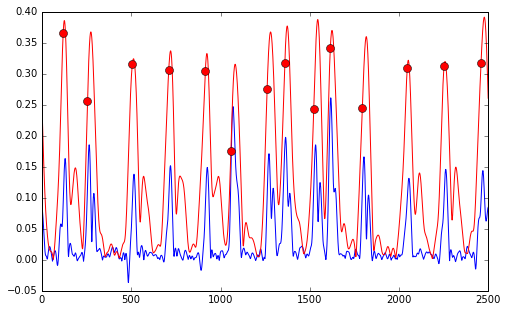

v139l on channel II with max ventricular HR:  127.118644068


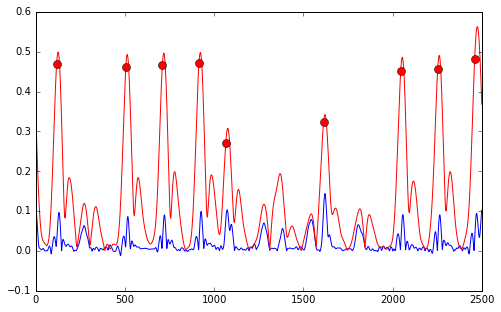

v139l on channel V with max ventricular HR:  80.3571428571
True


In [39]:
def test_ventricular_tachycardia(data_path, 
                                 ann_path, 
                                 fp_ann_path,
                                 sample_name, 
                                 ecg_ann_type,
                                 verbose=False,
                                 fs=parameters.DEFAULT_ECG_FS, 
                                 order=parameters.ORDER, 
                                 num_beats=parameters.VTACH_NUM_BEATS,
                                 std_threshold=parameters.VTACH_ABP_THRESHOLD,
                                 window_size=parameters.VTACH_WINDOW_SIZE,
                                 rolling_increment=parameters.VTACH_ROLLING_INCREMENT): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in seconds
    start_time, end_time, alarm_duration = invalid.get_start_and_end(fields)
    alarm_sig = sig[int(start_time*fs):int(end_time*fs),:]
    
    ecg_channels = invalid.get_channels_of_type(channels, "ECG")
    abp_channels = invalid.get_channels_of_type(channels, "BP")
    
    # Initialize R vector
    size = int((alarm_duration - window_size) / rolling_increment) + 1
    r_vector = [0.] * size
    
    # Adjust R vector based on ventricular beats in signal
    for channel_index in ecg_channels:
        index = int(channel_index)
        ann_type = annotate.get_ann_type(channels[index], index, ecg_ann_type)
        r_delta = get_ventricular_beats_scores(alarm_sig[:,index], ann_path, sample_name, ann_type, start_time, end_time)
        r_vector = r_vector + r_delta
                
        if verbose: 
            channel_sig = alarm_sig[:,index]
            lf, sub = get_lf_sub(channel_sig, order)
            ventricular_beats = ventricular_beat_annotations(lf, sub, ann_path + sample_name, ann_type, start_time, end_time, verbose)
            max_hr = max_ventricular_hr(ventricular_beats, num_beats, fs)
            print str(sample_name) + " on channel "  + str(channels[int(channel_index)]) + " with max ventricular HR: ", str(max_hr)

        
    # Adjust R vector based on whether standard deviation of ABP channel is > or < the threshold
    for channel_index in abp_channels: 
        r_delta = get_abp_std_scores(alarm_sig[:,channel_index], std_threshold, window_size, rolling_increment)
        r_vector = r_vector + r_delta
          
    return any([ r_value > 0 for r_value in r_vector ])

sample_name = "v139l"
# sample_name = "v784s" # false alarm
# sample_name = "v803l" # true alarm
print test_ventricular_tachycardia(data_path, ann_path, sample_name, ecg_ann_type, True)

## Ventricular flutter/fibrillation

In [20]:
def calculate_dlfmax(channel_sig, 
                     order=parameters.ORDER): 
    lf, sub = get_lf_sub(channel_sig, order)
    
    current_dlfmax_start = None
    dlfmax_duration = 0
    prev_low_dominance = 0
    
    for index in range(len(lf)): 
        lf_sample = lf[index]
        sub_sample = sub[index]
        
        if lf_sample > sub_sample: 
            # If not yet started a low dominance area, set the start index
            if current_dlfmax_start is None: 
                current_dlfmax_start = index
                            
            # If a separate low dominance area, reset
            elif index - prev_low_dominance > parameters.VFIB_LOW_DOMINANCE_INDEX_THRESHOLD: 
                # Calculate duration of previous low dominance area and update max dlfmax
                duration = prev_low_dominance - current_dlfmax_start
                dlfmax_duration = max(dlfmax_duration, duration)
                
                # Start new area of low dominance
                current_dlfmax_start = index
            
            # Update previous index seen with low frequency dominance
            prev_low_dominance = index
          
        # Handle duration at the end of the segment
        if current_dlfmax_start is not None: 
            duration = prev_low_dominance - current_dlfmax_start
            dlfmax_duration = max(dlfmax_duration, duration)
                        
    return dlfmax_duration
            

# Get dominant freq in signal in rolling window
def get_dominant_freq_array(channel_sig, 
                            fs=parameters.DEFAULT_ECG_FS,
                            window_size=parameters.VFIB_WINDOW_SIZE,
                            rolling_increment=parameters.VFIB_ROLLING_INCREMENT): 
    
    end = window_size * fs
    dominant_freqs = np.array([])
    
    while end < channel_sig.size: 
        start = end - window_size * fs
        channel_subsig = channel_sig[start:end]
        end += (rolling_increment * fs)
        
        xf, fft = invalid.get_signal_fft(channel_subsig, window_size, fs)
        
        # Index of the fft is 2 * the actual frequency 
        dominant_freq = np.argmax(fft) / 2
        
        dominant_freqs = np.append(dominant_freqs, dominant_freq)
    return dominant_freqs


def get_regular_activity_array(sig,
                               fields,
                               ann_path, 
                               sample_name,
                               ecg_ann_type,
                               arrhythmia_type="Ventricular_Flutter_Fib",
                               fs=parameters.DEFAULT_ECG_FS,
                               window_size=parameters.VFIB_WINDOW_SIZE,
                               rolling_increment=parameters.VFIB_ROLLING_INCREMENT): 
    regular_activity_array = np.array([])
    end = window_size * fs
    
    while end < sig[:,0].size: 
        start = end - window_size * fs
        subsig = sig[start:end]
        
        invalids_dict = invalid.calculate_invalids_sig(subsig, fields)
        rr_dict = annotate.get_rr_dict(ann_path, sample_name, fields, ecg_ann_type, start/fs, end/fs)
                
        is_regular = regular.is_rr_invalids_regular(rr_dict, invalids_dict, window_size, arrhythmia_type)
        if is_regular: 
            regular_activity_array = np.append(regular_activity_array, 1)
        else: 
            regular_activity_array = np.append(regular_activity_array, 0)

        end += (rolling_increment * fs)
    
    return regular_activity_array

def adjust_dominant_freqs(dominant_freqs, regular_activity): 
    adjusted_dominant_freqs = np.array([])
    
    for freq, is_regular in zip(dominant_freqs, regular_activity): 
        if is_regular: 
            adjusted_dominant_freqs = np.append(adjusted_dominant_freqs, 0)
        else: 
            adjusted_dominant_freqs = np.append(adjusted_dominant_freqs, freq)
    
    return adjusted_dominant_freqs

In [21]:
def test_ventricular_flutter_fibrillation(data_path, 
                                          ann_path, 
                                          sample_name, 
                                          ecg_ann_type,
                                          verbose=False,
                                          fs=parameters.DEFAULT_ECG_FS,
                                          ann_fs=parameters.DEFAULT_ECG_FS,
                                          std_threshold=parameters.VFIB_ABP_THRESHOLD,
                                          window_size=parameters.VFIB_WINDOW_SIZE,
                                          rolling_increment=parameters.VFIB_ROLLING_INCREMENT):
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    alarm_sig = sig[start*fs:end*fs,:]

    ecg_channels = invalid.get_channels_of_type(channels, "ECG")
    abp_channels = invalid.get_channels_of_type(channels, "BP")
    
    # Find max duration of low frequency signal from all channels
    dlfmax = 0
    for channel_index in ecg_channels: 
        channel_dlfmax = calculate_dlfmax(alarm_sig[:,channel_index])
        dlfmax = max(dlfmax, channel_dlfmax)
                    
    # Initialize R vector to a value based on the D_lfmax (duration of low frequency)
    if dlfmax > parameters.VFIB_DLFMAX_LIMIT: 
        r_vector_value = 1.
    else: 
        r_vector_value = 0.
    size = int((alarm_duration - window_size) / rolling_increment) + 1
    r_vector = [r_vector_value] * size
        
    # Adjust R vector based on whether standard deviation of ABP channel is > or < the threshold
    for channel_index in abp_channels: 
        r_delta = get_abp_std_scores(alarm_sig[:,channel_index], std_threshold, window_size, rolling_increment)
        r_vector = r_vector + r_delta
            
    # Adjust R vector based on dominant frequency in signal
    for channel_index in ecg_channels: 
        dominant_freqs = get_dominant_freq_array(alarm_sig[:,channel_index])
        regular_activity = get_regular_activity_array(alarm_sig, fields, ann_path, sample_name, ecg_ann_type)
        adjusted_dominant_freqs = adjust_dominant_freqs(dominant_freqs, regular_activity)
        
        new_r_vector = np.array([])
        for dominant_freq, r_value in zip(adjusted_dominant_freqs, r_vector): 
            if dominant_freq < parameters.VFIB_DOMINANT_FREQ_THRESHOLD: 
                new_r_vector = np.append(new_r_vector, 0.)
            else: 
                new_r_vector = np.append(new_r_vector, r_value)
        
        r_vector = new_r_vector
    
    return any([ r_value > 0 for r_value in r_vector ])

# sample_name = "f593l"
sample_name = "f450s" # false negative --> fixed
# sample_name = "f543l" # true positive
# print test_ventricular_flutter_fibrillation(data_path, ann_path, sample_name, ecg_ann_type)